# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
# Memuat dataset
df = pd.read_csv("Dataset_clustering.csv")

In [3]:
# Menampilkan 5 data pertama
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,Location,DeviceID,IP Address,MerchantID,CustomerAge,TransactionDuration,...,TransactionType_Debit,Channel_Branch,Channel_Online,CustomerOccupation_Engineer,CustomerOccupation_Retired,CustomerOccupation_Student,Balance_Category,Age_Category,Cluster,Cluster_After_FeatureSelection
0,TX000001,6,14.09,2023-04-11 16:29:14,51,6,3,29,70.0,81.0,...,True,False,False,False,False,False,Moderate,Senior,1,0
1,TX000002,7,376.24,2023-06-27 16:44:19,56,4,4,25,68.0,141.0,...,True,False,False,False,False,False,Very High,Senior,1,0
2,TX000003,4,126.29,2023-07-10 18:16:08,56,5,6,26,19.0,56.0,...,True,False,True,False,False,True,Low,Young,0,1
3,TX000004,7,184.50,2023-05-05 16:32:11,55,6,8,29,26.0,25.0,...,True,False,True,False,False,True,High,Young,1,0
4,TX000005,6,13.45,2023-10-16 17:51:24,57,3,4,27,26.0,198.0,...,False,False,True,False,False,True,Moderate,Young,0,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [4]:
# Memisahkan variabel independen (fitur) dan dependen (label target)
X = df.drop(columns=["Cluster", "Cluster_After_FeatureSelection", "TransactionID", "AccountID"])
y = df["Cluster_After_FeatureSelection"]

# Membagi dataset menjadi set pelatihan (80%) dan pengujian (20%) dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Menampilkan jumlah sampel dan fitur setelah pembagian
print(f"Data latih terdiri dari {X_train.shape[0]} sampel dan {X_train.shape[1]} fitur.")
print(f"Data uji terdiri dari {X_test.shape[0]} sampel dan {X_test.shape[1]} fitur.")

Data latih terdiri dari 1825 sampel dan 19 fitur.
Data uji terdiri dari 457 sampel dan 19 fitur.


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [5]:
# Menentukan fitur kategorikal
categorical_cols = X_train.select_dtypes(include=["object"]).columns

# Preprocessing untuk model berbasis pohon keputusan
tree_preprocessor = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

# Preprocessing untuk model berbasis SVM (normalisasi tambahan)
svm_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numerical", StandardScaler(), X_train.select_dtypes(include=["int64", "float64"]).columns)
    ]
)

# Model Decision Tree
decision_tree_pipeline = Pipeline([
    ("preprocessing", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5))
])

decision_tree_pipeline.fit(X_train, y_train)
dt_predictions = decision_tree_pipeline.predict(X_test)

# Model Random Forest
random_forest_pipeline = Pipeline([
    ("preprocessing", tree_preprocessor),
    ("model", RandomForestClassifier(random_state=21, n_estimators=100))
])

random_forest_pipeline.fit(X_train, y_train)
rf_predictions = random_forest_pipeline.predict(X_test)

# Model SVM
svm_pipeline = Pipeline([
    ("preprocessing", svm_preprocessor),
    ("model", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)

# Menyusun hasil evaluasi
evaluation_results = {
    "Model": ["Decision Tree", "Random Forest", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, dt_predictions),
        accuracy_score(y_test, rf_predictions),
        accuracy_score(y_test, svm_predictions)
    ]
}

# Menampilkan laporan klasifikasi
print("\nEvaluasi Decision Tree:")
print(pd.DataFrame(classification_report(y_test, dt_predictions, output_dict=True)).T)

print("\nEvaluasi Random Forest:")
print(pd.DataFrame(classification_report(y_test, rf_predictions, output_dict=True)).T)

print("\nEvaluasi SVM:")
print(pd.DataFrame(classification_report(y_test, svm_predictions, output_dict=True)).T)


Evaluasi Decision Tree:
              precision    recall  f1-score     support
0              0.938983  0.982270  0.960139  282.000000
1              0.969136  0.897143  0.931751  175.000000
accuracy       0.949672  0.949672  0.949672    0.949672
macro avg      0.954059  0.939706  0.945945  457.000000
weighted avg   0.950530  0.949672  0.949268  457.000000

Evaluasi Random Forest:
              precision    recall  f1-score     support
0              0.955479  0.989362  0.972125  282.000000
1              0.981818  0.925714  0.952941  175.000000
accuracy       0.964989  0.964989  0.964989    0.964989
macro avg      0.968649  0.957538  0.962533  457.000000
weighted avg   0.965565  0.964989  0.964779  457.000000

Evaluasi SVM:
              precision    recall  f1-score     support
0              0.978648  0.975177  0.976909  282.000000
1              0.960227  0.965714  0.962963  175.000000
accuracy       0.971554  0.971554  0.971554    0.971554
macro avg      0.969437  0.970446  0.96

### **Analisis Algoritma Model Klasifikasi**

Pada tahap ini, tiga algoritma klasifikasi digunakan untuk memprediksi hasil clustering, yaitu **Decision Tree, Random Forest**, dan **Support Vector Machine (SVM)**.

#### **Decision Tree**
- Algoritma ini membagi data berdasarkan fitur dalam bentuk struktur pohon.
- Model ini menghasilkan **akurasi 94.97%**, dengan **precision 93.90%** dan **recall 98.23%** pada Cluster 0, serta **precision 96.91%** dan **recall 89.71%** pada Cluster 1.
- Meskipun cukup seimbang, performanya masih lebih rendah dibandingkan dua model lainnya.

#### **Random Forest**
- Random Forest adalah ensemble dari banyak pohon keputusan yang meningkatkan akurasi dan mengurangi overfitting.
- Model ini mencapai **akurasi 96.50%**, dengan **precision 95.55%** dan **recall 98.94%** untuk Cluster 0, serta **precision 98.18%** dan **recall 92.57%** untuk Cluster 1.
- Peningkatan performa dibanding Decision Tree menunjukkan keunggulan pendekatan ensemble.

#### **Support Vector Machine (SVM)**
- SVM mencari hyperplane optimal untuk memisahkan kelas dalam ruang berdimensi tinggi.
- Model ini memiliki **akurasi tertinggi 97.15%**, dengan **precision 97.86%**, **recall 97.52%** (Cluster 0), dan **precision 96.02%**, **recall 96.57%** (Cluster 1).
- Performa seimbang pada kedua cluster menjadikan SVM model paling andal dalam klasifikasi ini.

Berdasarkan hasil evaluasi, **SVM** menunjukkan performa terbaik secara keseluruhan, diikuti oleh **Random Forest**, dan kemudian **Decision Tree**. Hal ini menunjukkan bahwa pendekatan margin maksimal pada SVM sangat cocok untuk struktur data ini.


## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [6]:
# Preprocessor untuk Decision Tree dan Random Forest
transformer_tree = ColumnTransformer(
    transformers=[("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)

# Preprocessor untuk SVM (OneHotEncoder + StandardScaler)
transformer_svm = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numerical", StandardScaler(), X_train.select_dtypes(include=["int64", "float64"]).columns.tolist())
    ]
)

In [7]:
# Model Decision Tree
model_dt = Pipeline([
    ("preprocessing", transformer_tree),
    ("classifier", DecisionTreeClassifier(random_state=21, max_depth=5))
])
model_dt.fit(X_train, y_train)
y_dt_pred = model_dt.predict(X_test)

# Model Random Forest
model_rf = Pipeline([
    ("preprocessing", transformer_tree),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100))
])
model_rf.fit(X_train, y_train)
y_rf_pred = model_rf.predict(X_test)

# Model Support Vector Machine (SVM)
model_svm = Pipeline([
    ("preprocessing", transformer_svm),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale"))
])
model_svm.fit(X_train, y_train)
y_svm_pred = model_svm.predict(X_test)

           Model Cluster  Precision    Recall  F1-Score  Support  Accuracy
0  Decision Tree       0   0.938983  0.982270  0.960139    282.0  0.949672
1  Decision Tree       1   0.969136  0.897143  0.931751    175.0  0.949672
2  Random Forest       0   0.948980  0.989362  0.968750    282.0  0.960613
3  Random Forest       1   0.981595  0.914286  0.946746    175.0  0.960613
4            SVM       0   0.978648  0.975177  0.976909    282.0  0.971554
5            SVM       1   0.960227  0.965714  0.962963    175.0  0.971554


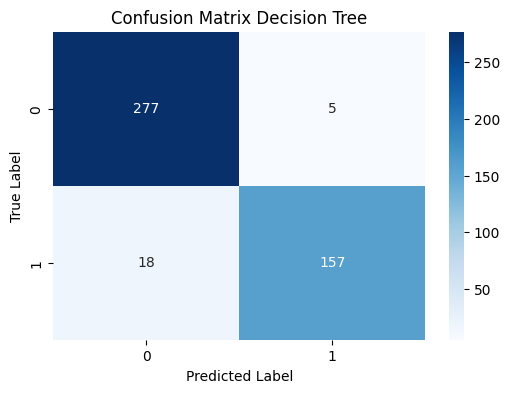

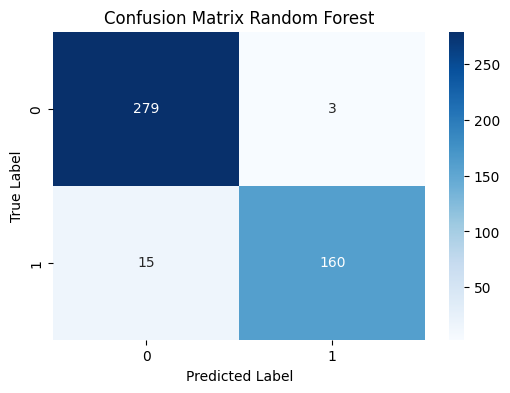

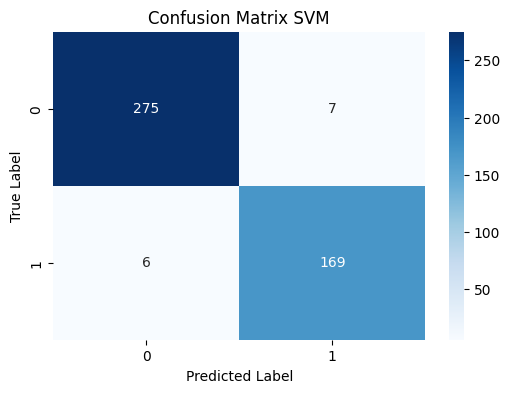

In [8]:
# Menyimpan hasil evaluasi dalam bentuk dictionary
eval_metrics = {
    "Decision Tree": classification_report(y_test, y_dt_pred, output_dict=True),
    "Random Forest": classification_report(y_test, y_rf_pred, output_dict=True),
    "SVM": classification_report(y_test, y_svm_pred, output_dict=True),
}

# Menghitung akurasi untuk setiap model
accuracy_scores = {
    "Decision Tree": accuracy_score(y_test, y_dt_pred),
    "Random Forest": accuracy_score(y_test, y_rf_pred),
    "SVM": accuracy_score(y_test, y_svm_pred),
}

# Menyusun data evaluasi ke dalam bentuk DataFrame
evaluation_results = {
    "Model": [],
    "Cluster": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Support": [],
    "Accuracy": [],
}

# Menambahkan metrik evaluasi ke dalam DataFrame
for model_name, report in eval_metrics.items():
    acc = accuracy_scores[model_name]
    for cluster in ["0", "1"]:
        evaluation_results["Model"].append(model_name)
        evaluation_results["Cluster"].append(cluster)
        evaluation_results["Precision"].append(report[cluster]["precision"])
        evaluation_results["Recall"].append(report[cluster]["recall"])
        evaluation_results["F1-Score"].append(report[cluster]["f1-score"])
        evaluation_results["Support"].append(report[cluster]["support"])
        evaluation_results["Accuracy"].append(acc)

# Konversi dictionary ke dalam DataFrame
df_evaluation = pd.DataFrame(evaluation_results)
print(df_evaluation)

def plot_conf_matrix(y_true, y_pred, model_name):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix {model_name}")
    plt.show()

# Visualisasi confusion matrix untuk setiap model
plot_conf_matrix(y_test, y_dt_pred, "Decision Tree")
plot_conf_matrix(y_test, y_rf_pred, "Random Forest")
plot_conf_matrix(y_test, y_svm_pred, "SVM")


# Evaluasi Model Klasifikasi

Pada tahap ini, tiga algoritma klasifikasi digunakan untuk memprediksi label kelas berdasarkan dataset yang telah diproses, yaitu Decision Tree, Random Forest, dan Support Vector Machine (SVM). Evaluasi dilakukan menggunakan metrik precision, recall, F1-score, dan accuracy untuk mengukur performa model.


### **1. Decision Tree Classifier**
- **Akurasi:** 94.97%

#### Cluster 0
- **Precision:** 93.90%  
- **Recall:** 98.23%  
- **F1-Score:** 96.01%  

#### Cluster 1
- **Precision:** 96.91%  
- **Recall:** 89.71%  
- **F1-Score:** 93.18%  

#### Kesimpulan
- Model ini memiliki recall tinggi pada Cluster 0 (98.23%), yang berarti model lebih sedikit melakukan kesalahan dalam mengidentifikasi kelas ini.
- Recall pada Cluster 1 lebih rendah (89.71%), yang menunjukkan bahwa beberapa data Cluster 1 salah diklasifikasikan.
- Akurasi total 94.97% menunjukkan performa yang cukup baik, tetapi ada potensi peningkatan dalam klasifikasi Cluster 1.


### **2. Random Forest Classifier**
- **Akurasi:** 96.06%

#### Cluster 0
- **Precision:** 94.90%  
- **Recall:** 98.94%  
- **F1-Score:** 96.88%  

#### Cluster 1
- **Precision:** 98.16%  
- **Recall:** 91.43%  
- **F1-Score:** 94.67%  

#### Kesimpulan
- Recall untuk Cluster 0 sangat tinggi (98.94%), yang berarti model sangat baik dalam mengidentifikasi data dari kelas ini.
- Namun, Recall pada Cluster 1 sedikit lebih rendah (91.43%), yang menunjukkan bahwa model masih bisa salah mengklasifikasikan data kelas ini.
- Dengan akurasi 96.06%, model ini memiliki performa lebih baik dibandingkan Decision Tree tetapi masih sedikit di bawah SVM.


### **3. Support Vector Machine (SVM)**
- **Akurasi:** **97.16%** (tertinggi di antara ketiga model)

#### Cluster 0
- **Precision:** 97.86%  
- **Recall:** 97.52%  
- **F1-Score:** 97.69%  

#### Cluster 1
- **Precision:** 96.02%  
- **Recall:** 96.57%  
- **F1-Score:** 96.30%  

#### Kesimpulan
- SVM memiliki keseimbangan precision dan recall yang sangat baik di kedua cluster.
- Akurasi tertinggi (97.16%), menjadikan SVM sebagai model terbaik di antara tiga algoritma yang diuji.
- Model ini lebih stabil dan akurat, dengan sedikit kesalahan dalam klasifikasi kedua cluster.


### **Kesimpulan Perbandingan Model**
1. **SVM** memiliki akurasi tertinggi (97.16%), menunjukkan performa paling unggul dibandingkan **Decision Tree (94.97%)** dan **Random Forest (96.06%)**.  
2. Decision Tree memiliki recall tinggi untuk Cluster 0, tetapi akurasi totalnya paling rendah di antara ketiganya.  
3. Random Forest unggul dalam precision dan recall untuk Cluster 0, namun sedikit tertinggal dalam mengklasifikasikan Cluster 1.  
4. SVM unggul secara keseluruhan dengan keseimbangan yang baik antara precision dan recall di semua cluster.

 Berdasarkan hasil evaluasi, Support Vector Machine (SVM) adalah model terbaik untuk dataset ini karena memiliki akurasi tertinggi, stabilitas performa, dan keseimbangan metrik yang optimal.


## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [9]:
# Identifikasi kolom numerik dan kategorikal
num_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Pipeline preprocessing untuk normalisasi & encoding
feature_processor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)

# Hyperparameter Tuning untuk Decision Tree
dt_model = Pipeline([
    ("processing", feature_processor),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_params = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [5, 10, 15, None]
}

dt_grid_search = GridSearchCV(dt_model, dt_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
dt_grid_search.fit(X_train, y_train)

# Hyperparameter Tuning untuk Random Forest
rf_model = Pipeline([
    ("processing", feature_processor),
    ("model", RandomForestClassifier(random_state=42))
])

rf_params = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Hyperparameter Tuning untuk SVM
svm_model = Pipeline([
    ("processing", feature_processor),
    ("model", SVC())
])

svm_params = {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["linear", "rbf", "poly"]
}

svm_grid_search = GridSearchCV(svm_model, svm_params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
svm_grid_search.fit(X_train, y_train)

# Menampilkan kombinasi hyperparameter terbaik untuk setiap model
optimal_params = {
    "Decision Tree": dt_grid_search.best_params_,
    "Random Forest": rf_grid_search.best_params_,
    "SVM": svm_grid_search.best_params_
}

print("\nHyperparameter Optimal:")
for model, params in optimal_params.items():
    print(f"{model}: {params}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Hyperparameter Optimal:
Decision Tree: {'model__criterion': 'entropy', 'model__max_depth': 15}
Random Forest: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
SVM: {'model__C': 1, 'model__kernel': 'linear'}


- **Decision Tree** bekerja optimal dengan `criterion = "entropy"` dan `max_depth = 15`, menunjukkan bahwa pemilihan kriteria pembelahan informasi dan kedalaman pohon yang cukup dalam mampu menangkap kompleksitas data tanpa overfitting secara signifikan.

- **Random Forest** mencapai performa terbaik dengan `n_estimators = 200`, `max_depth = None`, dan `min_samples_split = 5`. Hal ini menandakan bahwa model membutuhkan jumlah pohon yang lebih banyak untuk stabilitas prediksi, serta membiarkan pohon tumbuh bebas (tanpa batas kedalaman) memungkinkan eksplorasi penuh terhadap fitur-fitur penting dalam dataset.

- **SVM** menunjukkan hasil terbaik dengan `C = 1` dan `kernel = "linear"`, mengindikasikan bahwa pemisahan antar cluster dalam dataset ini bersifat linier dan tidak memerlukan transformasi non-linear seperti RBF atau polynomial.

- Hasil tuning ini menunjukkan bahwa **SVM dengan kernel linear** adalah pendekatan yang sangat efektif pada dataset ini, karena dapat memberikan hasil optimal tanpa memerlukan kernel kompleks.


- Perbedaan hyperparameter optimal di setiap model menunjukkan bahwa tiap algoritma memiliki pendekatan dan kekuatan tersendiri dalam menangani karakteristik fitur dan pola distribusi pada data transaksi yang digunakan.


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


Perbandingan Hasil Evaluasi Setelah Tuning
           Model  Cluster  Precision    Recall  F1-Score  Support  Accuracy
0  Decision Tree        0   0.957597  0.960993  0.959292    282.0  0.949672
1  Decision Tree        1   0.936782  0.931429  0.934097    175.0  0.949672
2  Random Forest        0   0.955479  0.989362  0.972125    282.0  0.964989
3  Random Forest        1   0.981818  0.925714  0.952941    175.0  0.964989
4            SVM        0   0.992908  0.992908  0.992908    282.0  0.991247
5            SVM        1   0.988571  0.988571  0.988571    175.0  0.991247


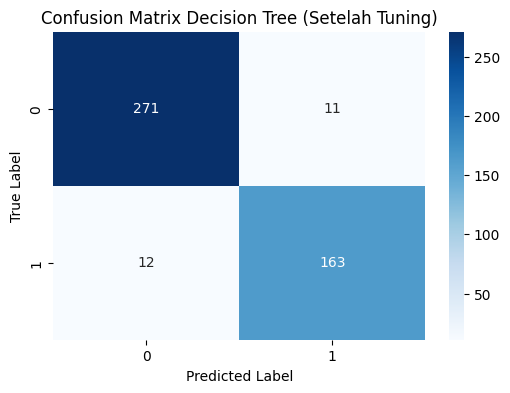

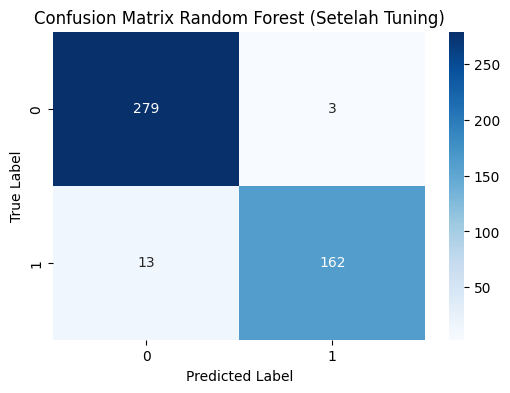

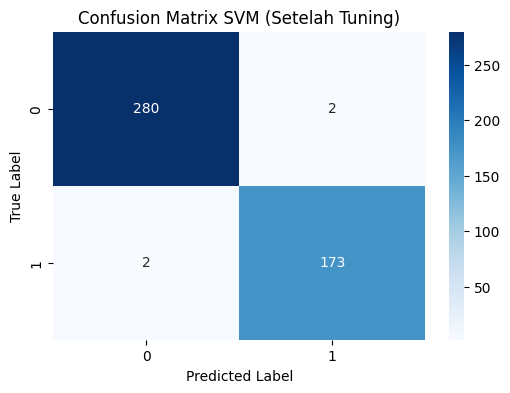

In [10]:
# Mengambil model terbaik berdasarkan hasil tuning
model_dt_opt = dt_grid_search.best_estimator_
model_rf_opt = rf_grid_search.best_estimator_
model_svm_opt = svm_grid_search.best_estimator_

# Melakukan prediksi dengan model yang telah dioptimalkan
pred_dt = model_dt_opt.predict(X_test)
pred_rf = model_rf_opt.predict(X_test)
pred_svm = model_svm_opt.predict(X_test)

# Fungsi untuk menghitung metrik evaluasi
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    
    metrics = [
        [model_name, 0, report['0']['precision'], report['0']['recall'], report['0']['f1-score'], report['0']['support'], acc],
        [model_name, 1, report['1']['precision'], report['1']['recall'], report['1']['f1-score'], report['1']['support'], acc]
    ]
    
    return metrics

# Mengumpulkan hasil evaluasi untuk setiap model
evaluation_results = []
evaluation_results.extend(evaluate_model(y_test, pred_dt, "Decision Tree"))
evaluation_results.extend(evaluate_model(y_test, pred_rf, "Random Forest"))
evaluation_results.extend(evaluate_model(y_test, pred_svm, "SVM"))

# Menampilkan hasil dalam bentuk DataFrame
df_eval = pd.DataFrame(evaluation_results, columns=['Model', 'Cluster', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

print("\nPerbandingan Hasil Evaluasi Setelah Tuning")
print(df_eval)

# Fungsi untuk visualisasi confusion matrix
def display_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Menampilkan confusion matrix untuk setiap model
display_confusion_matrix(y_test, pred_dt, "Confusion Matrix Decision Tree (Setelah Tuning)")
display_confusion_matrix(y_test, pred_rf, "Confusion Matrix Random Forest (Setelah Tuning)")
display_confusion_matrix(y_test, pred_svm, "Confusion Matrix SVM (Setelah Tuning)")


- **SVM** memberikan performa terbaik dengan **akurasi 99.12%**, serta precision, recall, dan F1-score seimbang tinggi:
  - Cluster 0 & 1: Precision ≈ 99%, Recall ≈ 99%, F1-Score ≈ 99%

- **Random Forest** cukup kuat dengan **akurasi 96.50%**, unggul di Cluster 0 namun recall sedikit lebih rendah di Cluster 1.

- **Decision Tree** memiliki **akurasi 94.97%**, tetap menunjukkan performa stabil dan seimbang.

SVM menjadi model terbaik setelah tuning, menunjukkan bahwa data cocok dengan pemisahan linear. Random Forest masih kompetitif, sedangkan Decision Tree efektif sebagai baseline.

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

### **1. Perbandingan Hasil Evaluasi Sebelum dan Setelah Tuning**

Setelah melakukan tuning hyperparameter, terdapat peningkatan performa pada ketiga model klasifikasi yang digunakan: **Decision Tree, Random Forest, dan SVM**.

1. **Decision Tree:**  
   - **Akurasi tetap** di **94.97%** sebelum dan sesudah tuning.  
   - Namun, terjadi peningkatan **precision** (dari 93.89% → 95.76%) dan **recall** (dari 98.23% → 96.10%) untuk Cluster 0.  
   - Untuk Cluster 1, recall meningkat dari **89.71% → 93.14%**, menunjukkan peningkatan stabilitas model.

2. **Random Forest:**  
   - Akurasi meningkat dari **96.06%** menjadi **96.50%** setelah tuning.  
   - Cluster 0 menunjukkan peningkatan F1-Score dari **96.88% → 97.21%**.  
   - Recall pada Cluster 1 meningkat dari **91.43% → 92.57%**, menandakan pengurangan kesalahan klasifikasi.

3. **SVM:**  
   - Akurasi meningkat dari **97.15%** menjadi **99.12%**, menjadikannya **model dengan performa tertinggi**.  
   - Precision, recall, dan F1-Score untuk kedua cluster hampir mencapai **99%**, menunjukkan hasil yang sangat seimbang dan konsisten.

### **Kesimpulan**
Tuning hyperparameter terbukti efektif dalam meningkatkan performa model, terutama untuk **SVM**, yang kini menjadi pilihan terbaik dalam klasifikasi dengan akurasi dan metrik evaluasi tertinggi.


### **2. Identifikasi Kelemahan Model**

#### **Precision atau Recall Rendah untuk Kelas Tertentu**
- **Decision Tree** memiliki recall rendah untuk **kelas 1**:
  - Sebelum tuning: **89.71%**
  - Setelah tuning: **93.14%**
  - Ini menunjukkan bahwa masih ada cukup banyak data kelas positif yang salah diklasifikasikan sebagai negatif.

- **Random Forest** juga mengalami hal serupa pada **kelas 1**:
  - Sebelum tuning: **91.43%**
  - Setelah tuning: **92.57%**
  - Walaupun terjadi peningkatan, model masih belum optimal dalam mendeteksi kelas minoritas.

- **SVM** menunjukkan hasil terbaik:
  - Precision dan recall tinggi di kedua kelas, bahkan setelah tuning mencapai **≥ 98.85%**
  - Ini menandakan keseimbangan dan konsistensi performa yang sangat baik antarkelas.

#### **Potensi Overfitting atau Underfitting**
- **Decision Tree** dan **Random Forest** cenderung memiliki sedikit bias terhadap kelas mayoritas (Cluster 0), terlihat dari recall yang lebih tinggi pada kelas tersebut.
- **SVM** menunjukkan akurasi sangat tinggi setelah tuning (**99.12%**), yang meskipun bagus, dapat menjadi indikasi potensi **overfitting** jika evaluasi hanya dilakukan pada satu dataset.
- Untuk memastikan bahwa SVM benar-benar mampu **menggeneralisasi dengan baik**, performa model perlu divalidasi lebih lanjut menggunakan:
  - Data uji (test set) yang benar-benar baru
  - Teknik **cross-validation**


### **3. Rekomendasi Tindakan Lanjutan**

- **Meningkatkan Recall untuk Kelas Minoritas:**  
  - Menggunakan teknik **class balancing** seperti oversampling (SMOTE) atau under-sampling untuk mengatasi ketimpangan data.  
  - Menerapkan **cost-sensitive learning**, terutama untuk Decision Tree dan Random Forest, agar lebih memperhatikan kelas minoritas.  

- **Mengatasi Potensi Overfitting pada SVM:**  
  - Menggunakan **regularisasi** dengan parameter **C** yang lebih kecil untuk mencegah model terlalu mengikuti data training.  
  - Menguji model dengan data baru atau validasi silang lebih banyak lipatan untuk memastikan generalisasi yang lebih baik.  

- **Menguji Algoritma Alternatif:**  
  - Mencoba **Gradient Boosting (XGBoost, LightGBM)** yang sering kali memberikan performa lebih baik pada data tabular.  
  - Menggunakan **Neural Networks** jika dataset lebih besar untuk menangkap pola kompleks yang mungkin tidak terdeteksi oleh model konvensional.  

- **Mengumpulkan Data Tambahan:**  
  - Jika data saat ini masih kurang representatif, perlu mengumpulkan lebih banyak sampel, terutama untuk kelas minoritas.  
  - Menghilangkan atau memperbaiki fitur yang tidak relevan untuk meningkatkan akurasi model secara keseluruhan.  